# Initialize system

In [ ]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

In [ ]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]

In [4]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0xdeadbeef
0xdeadbeef


In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet registers
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading packet registers
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor

In [7]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableAllAsics(False)
root.enableAsic(3, True)
DEBUG3.enableDataDebug(True)
DEBUG3.cleanData()

# Lorenzo - Helper functions

In [8]:
%run dataProcFunctions.ipynb     #this is were my function was stored

# Set registers and variables

In [13]:
# Set some registers...
ASIC3.CompTH_ePixM.set(0)

# Reference pixel
ref_row = 100
ref_col = 150

# Define empty arrays

noise   = np.empty([8,8])
gain    = np.empty([8,8])

for RefN_val, RefP_val in np.ndindex(8,8):
    print('--- Acquiring data value {}/{} ---'.format(RefN_val,RefP_val))
    ASIC3.RefinN.set(RefN_val)
    ASIC3.RefinP.set(RefP_val)
    # Get ramps and calculate gain
    ChInjValues, pixelRamp = ChInjRamp()
    gain[RefN_val,RefP_val] = np.polyfit(ChInjValues, pixelRamp, 1)[0]
    
    # Get darks and calculate noise
    data = readoutFrames(100)
    data_noisemap = np.std(data, axis=2)    
    noise[RefN_val,RefP_val] = np.median(data_noisemap)

print(noise)
print(gain)

--- Acquiring data value 0/0 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/1 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/2 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/3 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/4 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/5 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 0/6 ---
Data Descramb

Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 6/4 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 6/5 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 6/6 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 6/7 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 7/0 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 100)
--- Acquiring data value 7/1 ---
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descrambled
(192, 384, 3)
Data Descramble

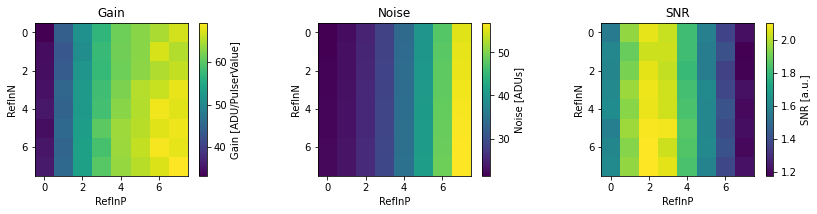

Recommended setting RefN/RefP:(array([6]), array([2]))


In [14]:
snr = abs(gain)/noise

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot the images on each subplot
im1 = axes[0].imshow(abs(gain), cmap='viridis')
im2 = axes[1].imshow(noise, cmap='viridis')
im3 = axes[2].imshow(snr, cmap='viridis')

# Set titles for each subplot
axes[0].set_title('Gain')
axes[1].set_title('Noise')
axes[2].set_title('SNR')

axes[0].set_xlabel('RefInP')
axes[1].set_xlabel('RefInP')
axes[2].set_xlabel('RefInP')

axes[0].set_ylabel('RefInN')
axes[1].set_ylabel('RefInN')
axes[2].set_ylabel('RefInN')

# Optionally, display the axes on each subplot
axes[0].axis('on')
axes[1].axis('on')
axes[2].axis('on')

# Add colorbars to each subplot
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar3 = fig.colorbar(im3, ax=axes[2])

# Set colorbar labels (optional)
cbar1.set_label('Gain [ADU/PulserValue]')
cbar2.set_label('Noise [ADUs]')
cbar3.set_label('SNR [a.u.]')

# Show the plots
plt.tight_layout()
plt.show()

print('Recommended setting RefN/RefP:{}'.format(np.where(snr == snr.max())))
